In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
import xlrd
from sklearn.decomposition import PCA 
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import (mean_squared_error,median_absolute_error)
pd.options.display.float_format = '{:.3f}'.format

In [2]:
file = ('C:\\Users\\Abe\\Data Science Bootcamp\\Unit 2\\Crime\\table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')
df = pd.read_excel(file, header=4)
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861.000,0.000,0.000,nan,0.000,0.000,0.000,12.000,2.000,10.000,0.000,0.000
1,Addison Town and Village,2577.000,3.000,0.000,nan,0.000,0.000,3.000,24.000,3.000,20.000,1.000,0.000
2,Akron Village,2846.000,3.000,0.000,nan,0.000,0.000,3.000,16.000,1.000,15.000,0.000,0.000
3,Albany,97956.000,791.000,8.000,nan,30.000,227.000,526.000,4090.000,705.000,3243.000,142.000,nan
4,Albion Village,6388.000,23.000,0.000,nan,3.000,4.000,16.000,223.000,53.000,165.000,5.000,nan


In [3]:
cols = ['city', 'population', 'violent_crime', 'murder_mans','rape1','rape2',
        'robbery', 'agg_ass','prop_crime','burglary','larc_theft','gta','arson']

df.columns = cols
dfcl = df.drop(['rape1','arson'],axis=1)
dfcl = dfcl.dropna()
dfcl.drop(dfcl[dfcl['population'] > 100000].index,inplace=True)

In [4]:
dfcl.head()

,city,population,violent_crime,murder_mans,rape2,robbery,agg_ass,prop_crime,burglary,larc_theft,gta
0,Adams Village,1861.000,0.000,0.000,0.000,0.000,0.000,12.000,2.000,10.000,0.000
1,Addison Town and Village,2577.000,3.000,0.000,0.000,0.000,3.000,24.000,3.000,20.000,1.000
2,Akron Village,2846.000,3.000,0.000,0.000,0.000,3.000,16.000,1.000,15.000,0.000
3,Albany,97956.000,791.000,8.000,30.000,227.000,526.000,4090.000,705.000,3243.000,142.000
4,Albion Village,6388.000,23.000,0.000,3.000,4.000,16.000,223.000,53.000,165.000,5.000


In [5]:
# Correlation of the data set.
# Prop_crime is the aggregation of burglary, larc_theft and gta so we cannot use those in our model
# violent_crime has the same issue

dfcl.drop(['violent_crime','burglary','larc_theft','gta','rape2'],axis=1,inplace=True)
dfcl.corr()

,population,murder_mans,robbery,agg_ass,prop_crime
population,1.000,0.490,0.643,0.627,0.849
murder_mans,0.490,1.000,0.797,0.779,0.593
robbery,0.643,0.797,1.000,0.950,0.773
agg_ass,0.627,0.779,0.950,1.000,0.813
prop_crime,0.849,0.593,0.773,0.813,1.000


c:\users\abe\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


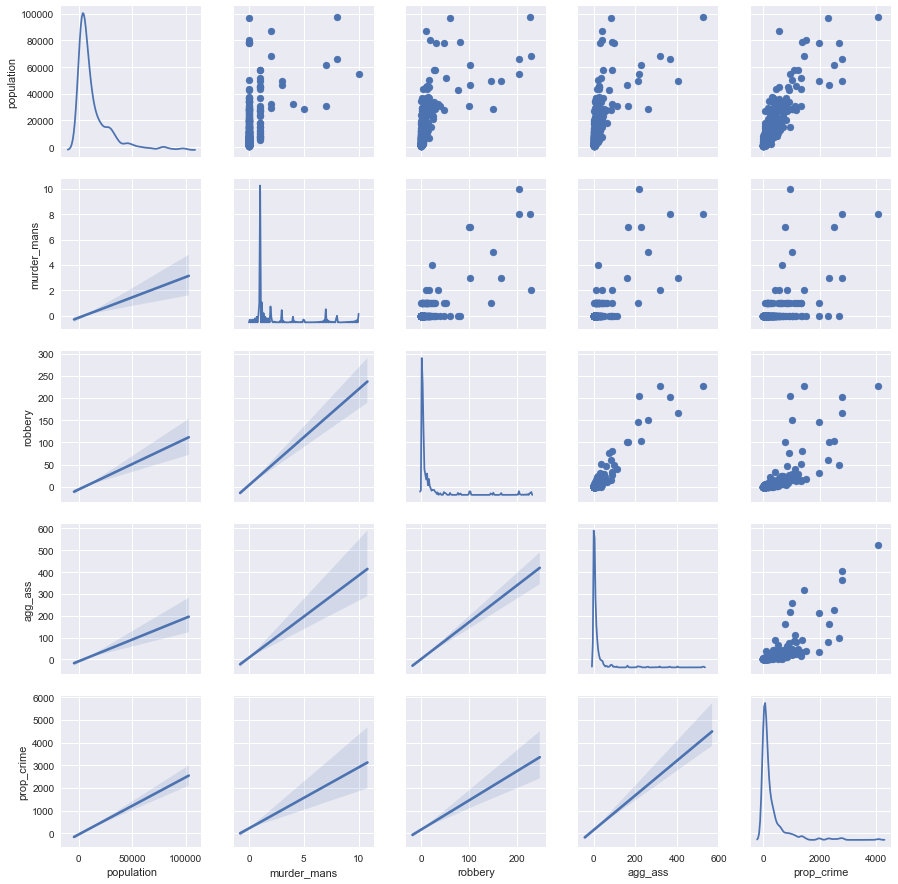

In [6]:
# Look at population outliers
# Removed largest city. Maybe remove cities less than 100K and only focus on small cities?
g = sns.PairGrid(dfcl, diag_sharey=False)
g.map_upper(plt.scatter)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot)
plt.show()

In [7]:
# Using statsmodels

linear_formula = 'prop_crime~population+murder_mans+robbery+agg_ass'
lm = smf.ols(formula=linear_formula, data=dfcl).fit()

print('R^2:\n{}\n'.format(lm.rsquared))
print('P Values:\n{}\n'.format(lm.pvalues))
print('Beta Values:\n{}\n'.format(lm.params))
lm.conf_int()

R^2:
0.858890834232392

P Values:
Intercept     0.179
population    0.000
murder_mans   0.041
robbery       0.001
agg_ass       0.000
dtype: float64

Beta Values:
Intercept     -17.976
population      0.017
murder_mans   -31.720
robbery        -3.798
agg_ass         6.769
dtype: float64



,0,1
Intercept,-44.242,8.290
population,0.016,0.019
murder_mans,-62.167,-1.272
robbery,-6.092,-1.503
agg_ass,5.549,7.989


In [8]:
# Predicting 2014 property crime

regr = LinearRegression()

predictors = ['population','murder_mans','robbery','agg_ass']

x = dfcl[predictors]
y = dfcl['prop_crime']

regr.fit(x, y)

# Import 2014 data
file = 'C:\\Users\\Abe\\Data Science Bootcamp\\Unit 2\\Crime\\Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls'
df2014 = pd.read_excel(file, header=4)
df2014.columns = cols
dfcl2014 = df2014.drop(['rape1','arson','rape2'],axis=1)
dfcl2014 = dfcl2014.dropna()
dfcl2014.drop(dfcl2014[dfcl2014['population'] > 100000].index,inplace=True)

y_true = dfcl2014['prop_crime']
y_predict = regr.predict(dfcl2014[predictors])

print(mean_squared_error(y_true,y_predict))
print(median_absolute_error(y_true,y_predict))
print(regr.predict(dfcl2014[predictors].ix[200:201]))
print(dfcl2014['prop_crime'].ix[200:201])

# Histogram of errors to check for skewdness

34889.3368918
46.8554908421
[ 185.99606754  225.38324339]
200    93.000
201   332.000
Name: prop_crime, dtype: float64


c:\users\abe\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


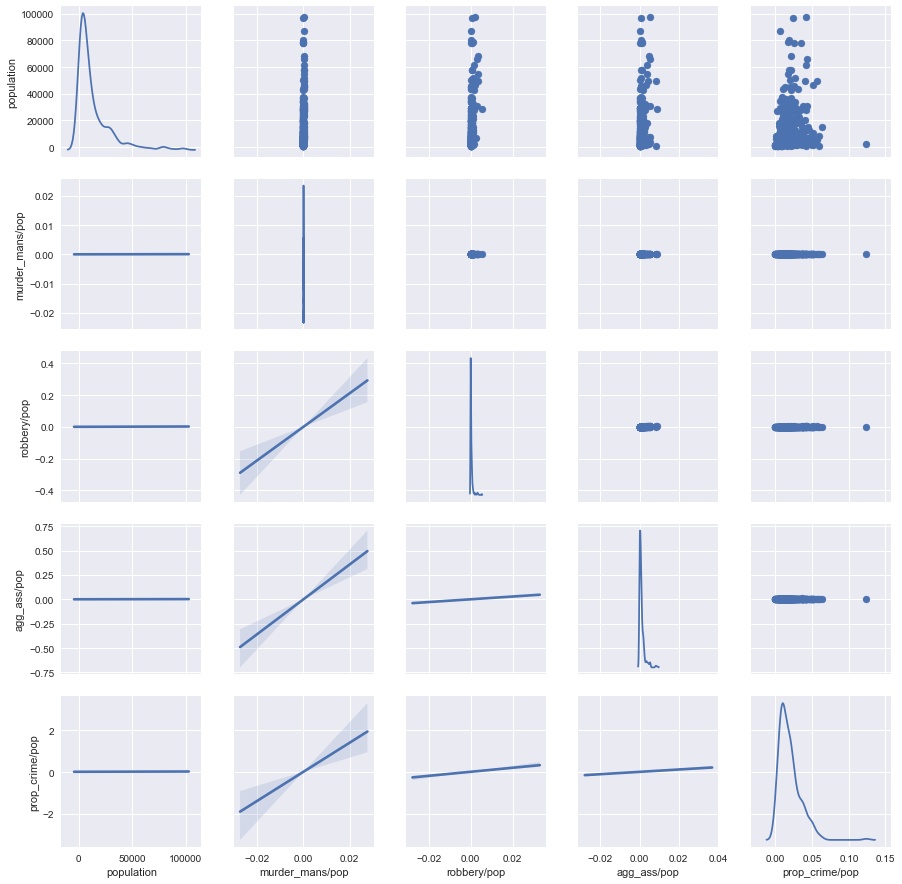

In [9]:
# What would happen if I used per capita features for crime instead of total?

cols = ['murder_mans','robbery','agg_ass','prop_crime']

for col in cols:
    dfcl[col + '/pop'] = dfcl[col] / dfcl['population']
    
df_ss = dfcl.drop(cols,axis=1)

g = sns.PairGrid(df_ss, diag_sharey=False)
g.map_upper(plt.scatter)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot)
plt.show()

In [12]:
# Fit the model with new variables and try and predict prop_crime in 2014 data again
regr = LinearRegression()

predictors = ['population','murder_mans/pop','robbery/pop','agg_ass/pop']

x = df_ss[predictors]
y = df_ss['prop_crime/pop']
regr.fit(x, y)

# Create predictor columns in 2014 data
for col in cols:
    dfcl2014[col + '/pop'] = dfcl2014[col] / dfcl2014['population']


# y_true is the same as before
y_predict = regr.predict(dfcl2014[predictors])
y_true = dfcl2014['prop_crime/pop']

print(mean_squared_error(y_true,y_predict))
print(median_absolute_error(y_true,y_predict))
print(regr.predict(dfcl2014[predictors].ix[200:201]))
print(dfcl2014['prop_crime/pop'].ix[200:201])

0.000363900110394
0.00776415108315
[ 0.01800525  0.02154293]
200   0.011
201   0.031
Name: prop_crime/pop, dtype: float64


48065.7092087
41.7741995524
48197.3997402


count     361.000
mean      -21.449
std       218.792
min     -1641.014
25%       -56.442
50%       -17.341
75%        12.857
max       940.610
dtype: float64

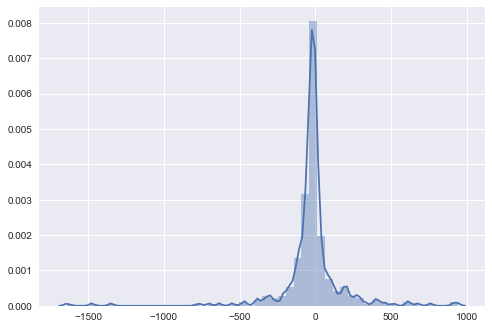

In [21]:
# Rescaled

print(mean_squared_error(y_true*dfcl2014['population'],y_predict*dfcl2014['population']))
print(median_absolute_error(y_true*dfcl2014['population'],y_predict*dfcl2014['population']))

error = y_true-y_predict
error = (error*dfcl2014['population'])[error < .25]

print(np.mean(error*error))

sns.distplot(error)

error.describe()

In [11]:
# No! Its worse!
# Let's look at the effect of just population

x = dfcl['population']
y = dfcl['prop_crime']

regr.fit(x.to_frame(),y.to_frame())

y_predict = regr.predict(dfcl2014['population'].to_frame())

print(mean_squared_error(y_true,y_predict))
print(median_absolute_error(y_true,y_predict))
print(regr.predict(dfcl2014['population'].ix[200:201].to_frame()))
print(dfcl2014['prop_crime'].ix[200:201])

63105.1818046
55.2506999571
[[ 174.09653551]
 [ 225.73333656]]
200    93.000
201   332.000
Name: prop_crime, dtype: float64


In [12]:
# I've iterated the wrong way...